### README

#### Weather Regime Clustering

**Overview**

This script performs clustering on zg500 weather data to identify distinct weather regimes. It includes the generation of cluster centroids based on a specific year and assigns individual runs to pre-existing clusters. This approach is used to prevent memory issues. The script uses Empirical Orthogonal Functions (EOFs), Principal Components (PCs), and KMeans clustering.

#### Instructions

**Prerequisites**
- Install required Python packages: `pandas`, `numpy`, `scikit-learn`, `xarray`, `cfgrib` (if the data is in GRIB format), `dask`, `netcdf4`, `eofs`.
- zg500 geopotential height data in Grib or NetCDF format is required.

**Configuration**
1. **File Paths:** Modify the `PATH` variable according to the location of your zg500 weather data.
2. **Constants:** Adjust constants such as `VERSION`, `USE_SCALING`, `N_EOFS`, `N_EOFS_FOR_KMEANS`, and `N_CLUSTERS` based on your preferences.
3. **Output Directory:** Update the `dir_Clusters` variable to specify where the cluster results will be saved.

**Author**

Bram van Duinen

**Date (last modified)**

2024-01-19

**Reference**

Adapted from: [Matteo De Felice's Recipe for Weather Regimes](https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb) (28 Nov 2023)

In [1]:
#REF: https://github.com/matteodefelice/a-recipe-for-weather-regimes/blob/main/recipe.ipynb
#TODO: Check license

### 1. Preliminaries

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
from eofs.xarray import Eof
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import pearsonr
from scipy import signal
from tqdm.notebook import tqdm
import time
import utils as ut

In [3]:
PATH = "/net/pc230050/nobackup/users/duinen/LENTIS/present/zg500_d/"
# constants
VERSION = 'Bayes_full_v1' # update this when you change the clustering algorithm and want to save the new results
USE_SCALING = 0
N_EOFS = 30
N_EOFS_FOR_KMEANS = 20
N_CLUSTERS = 4

dir_Clusters = f"../Results/clusters_{VERSION}/"
ut.check_make_dir(dir_Clusters)

### 2. Define functions

In [4]:
def load_data(year, run_mid = 90):
    """
    Load and preprocess zg500 data for a specific year, to calculate cluster centroids.

    Parameters:
    - year (int): The target year for data extraction.
    - run_mid (int): The middle run index for splitting the data.

    Returns:
    - df (xarray.DataArray): Preprocessed zg500 data.
    """
    filenames_1 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(10, run_mid)] 
    filenames_2 = [f"{PATH}zg500_d_ECEarth3_h{i:03d}.nc" for i in range(run_mid, 170)]

    df_1 = (
        xr.open_mfdataset(filenames_1, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        # .convert_calendar('noleap')
    )
    df_1 = df_1.where(
        (df_1['time'].dt.month.isin([11, 12, 1, 2, 3])) & 
        (df_1['time'].dt.year.isin([year])) & # only use one year per run for cluster centroids, add others later.
        (df_1['lon'] < 30) & 
        (df_1['lat'] > 20) & 
        (df_1['lat'] < 80), 
        drop=True
    )

    df_2 = (
        xr.open_mfdataset(filenames_2, concat_dim='time', combine="nested",
                        chunks={'longitude':31, 
                                'latitude': 16,
                                'time': -1})
        # .convert_calendar('noleap')
    )
    df_2 = df_2.where(
        (df_2['time'].dt.month.isin([11, 12, 1, 2, 3])) & 
        (df_2['time'].dt.year.isin([year])) & # only use one year per run for cluster centroids, add others later.
        (df_2['lon'] < 30) & 
        (df_2['lat'] > 20) & 
        (df_2['lat'] < 80), 
        drop=True
    )
    
    df = xr.concat([df_1, df_2], dim = 'time').zg500.load()
    
    df_original = df.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()
    return df_original

In [5]:
def load_data_per_run(run):
    """
    Load and preprocess zg500 data for a specific run.

    Parameters:
    - run (int): The run index for data extraction.

    Returns:
    - df (xarray.DataArray): Preprocessed zg500 data for the given run.
    """
    filename = [f"{PATH}zg500_d_ECEarth3_h{run:03d}.nc"] 

    df = (
        xr.open_mfdataset(filename)
        # .convert_calendar('noleap') #REVIEW: If it still works with noleap!
    )

    df = df.where(
        (df['time'].dt.month.isin([11, 12, 1, 2, 3])) & 
        (df['lon'] < 30) & 
        (df['lat'] > 20) & 
        (df['lat'] < 80), 
        drop=True
    )

    df = df.zg500.load()
    df_original = df.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = 'trim').mean()

    return df_original

In [6]:
def calculate_anomaly(da, groupby_type="time.dayofyear"):
    """
    Calculate anomalies based on a given grouping type (default = dayofyear).

    Parameters:
    - da (xarray.DataArray): Input climate data.
    - groupby_type (str): Grouping type for calculating anomalies.

    Returns:
    - Anomalies (xarray.DataArray): Calculated anomalies.
    """
    gb = da.groupby(groupby_type)
    clim = gb.mean(dim="time")
    return gb - clim

In [7]:
def calculate_eofs(df_anom):
    """
    Calculate Empirical Orthogonal Functions (EOFs) from anomaly data.

    Parameters:
    - df_anom (xarray.DataArray): Anomaly data.

    Returns:
    - solver, eofs, eofs_corr, explained_var: EOF-related results.
    """
    coslat = np.cos(np.deg2rad(df_anom.coords['lat'].values)).clip(0., 1.)
    wgts   = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(df_anom, weights=wgts)
    eofs = solver.eofs(neofs=N_EOFS)
    eofs_corr = solver.eofsAsCorrelation(neofs=N_EOFS)
    explained_var = solver.varianceFraction()
    return solver, eofs, eofs_corr, explained_var #REVIEW: if I really need all this

In [8]:
def calculate_pcs(solver, df_anom):
    """
    Calculate Principal Components (PCs) from solver and zg500 anomaly data.

    Parameters:
    - solver: EOF solver.
    - df_anom (xarray.DataArray): Anomaly data.

    Returns:
    - df_pcs (pd.DataFrame): Principal Components data.
    """
    pcs = solver.projectField(df_anom,
                          neofs=N_EOFS, 
                          eofscaling=USE_SCALING)

    df_pcs = (pcs
            .to_dataframe()
            .reset_index()
            .assign(run_index=lambda df: df.groupby(['time', 'mode']).cumcount())
            .pivot(index=['time', 'run_index'], columns='mode', values='pseudo_pcs')
            .add_prefix('EOF')
            )
    df_pcs.index = pd.to_datetime(df_pcs.index.get_level_values('time'))
    return df_pcs

In [9]:
def Kmeans_clustering(df_pcs):
    """
    Perform KMeans clustering on Principal Components.

    Parameters:
    - df_pcs (pd.DataFrame): Principal Components.

    Returns:
    - clus, cluster_center_array: Cluster assignments and centroids.
    """
    X_train = df_pcs.iloc[:, 0:N_EOFS_FOR_KMEANS].values
    km = KMeans(n_clusters=N_CLUSTERS, n_init=500, verbose=0, tol=0.000001, max_iter=500, random_state=3)
    km.fit(X_train)

    clus = pd.DataFrame(
        data=km.labels_, 
        columns=['cluster_id'], 
        index=df_pcs.index).reset_index()
    clus.rename(columns={'time': 'date'}, inplace=True)

    clus.set_index('date', inplace=True)

    # calculate centroids
    cluster_centers = pd.DataFrame(
        km.cluster_centers_, 
        columns=[f'eof{i}' for i in np.arange(1,N_EOFS_FOR_KMEANS+1)]
        )

    cluster_center_array = xr.DataArray(
        cluster_centers.values, 
        coords=[np.arange(0, N_CLUSTERS), np.arange(0, N_EOFS_FOR_KMEANS) ], 
        dims=['centroids', 'mode'])
    
    return clus, cluster_center_array

In [10]:
def original_space(cluster_center_array, eofs):
    """
    Transform cluster centroids from EOF space back to the original space.

    Parameters:
    - cluster_center_array: Centroids in EOF space.
    - eofs: Empirical Orthogonal Functions.

    Returns:
    - recons_cluster_centers_unweighted: Transformed cluster centroids.
    """
    eigenvectors20 = eofs.loc[0:N_EOFS_FOR_KMEANS, ...]
    recons_cluster_centers_weighted = cluster_center_array.dot(eigenvectors20)

    lats = recons_cluster_centers_weighted.coords['lat'].values

    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)

    weights_array = xr.DataArray(wgts, coords=[lats], dims=['lat'])
    recons_cluster_centers_unweighted = recons_cluster_centers_weighted / weights_array
    return recons_cluster_centers_unweighted

In [11]:
def plot_clusters(recons_cluster_centers_unweighted, lons, lats):
    """
    Plot zg500 clusters on a map.

    Parameters:
    - recons_cluster_centers_unweighted: Transformed cluster centers.
    - lons, lats: Longitude and Latitude values.
    """
    n_clusters = recons_cluster_centers_unweighted.shape[0]

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={'projection': ccrs.Orthographic(central_longitude=-30, central_latitude=50)})

    axs = axs.flatten()
    titles = ['Blocking', 'NAO -', 'NAO +', 'Atl. Ridge']
    for i, ax in enumerate(axs):
        if i < n_clusters:
            fill = ax.contourf(
                lons,
                lats,
                recons_cluster_centers_unweighted[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend='both',
                transform=ccrs.PlateCarree())

            ax.coastlines(resolution='50m')
            ax.gridlines()
            ax.set_title(titles[i], fontsize=12)

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation='vertical', label='500 hPa height anomaly [m]', extend='both', ticks=np.arange(-200, 250, 50))


In [12]:
def assign_cluster_df(X_assign, centroids, run_id, df):
    """
    Assign data points to clusters based on distances.

    Parameters:
    - X_assign: Data points to assign.
    - centroids: Cluster centroids.
    - run_id: Run identifier.
    - df: Original dataset with the data points.

    Returns:
    - df_cluster: Dataframe with cluster assignments.
    """
    assignments = []
    distances = []
    for data_point in X_assign:
        distances = np.linalg.norm(centroids - data_point, axis=1)
        cluster_assignment = np.argmin(distances)
        assignments.append(cluster_assignment)
        distances.append(distances)
  
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run_id,
        'cluster_id': assignments,
        'distances': distances
    })

    return df_cluster

In [13]:
def gen_clusters(year = 2005):
    """
    Generate zg500 cluster centroids based on a specific year.

    Parameters:
    - year (int): The target year for cluster generation.

    Returns:
    - clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs: Cluster-related results.
    """
    print(f"Generating clusters for base year {year}")
    print("Loading data")
    df = load_data(year)
    
    print("Calculating anomalies")
    start_time = time.time()
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    # df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()
    end_time = time.time()
    print(f"Anomalies calculated in {end_time - start_time} seconds")

    print("Calculating EOFs")
    solver, eofs, eofs_corr, explained_var = calculate_eofs(df_anom)

    print("Calculating PCs")
    df_pcs = calculate_pcs(solver, df_anom)

    print("Performing clustering")
    clus, cluster_center_array = Kmeans_clustering(df_pcs)
    recons_cluster_centers_unweighted = original_space(cluster_center_array, eofs)

    return clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs

In [14]:
def assign_to_cluster(run, centroids):
    """
    Assign individual runs to pre-existing clusters. 
    Also calculate pattern correlation, and apply no-cluster if correlation is too low.

    Parameters:
    - run (int): Run index for assignment.
    - centroids: Cluster centroids (in real space).
    """
    df = load_data_per_run(run)    
    df_anom = df.map_blocks(calculate_anomaly, template=df.load())
    # df_anom['time'] = df_anom.indexes['time'].to_datetimeindex()

    assignments = []
    all_errors = []
    correlations = []
    
    for data_point in df_anom:
        distances = np.linalg.norm(centroids - data_point, axis=(1,2))
        # this part to add no-regime part if there is no significant improvement
        cluster_assignment = np.argmin(distances)
        corr = np.corrcoef(data_point.values.flatten(), centroids[cluster_assignment].values.flatten())[0, 1]
        # if corr < 0.3:
        #     cluster_assignment = 4

        assignments.append(cluster_assignment)
        all_errors.append(distances.tolist())
        correlations.append(corr)
    
    df_cluster = pd.DataFrame({
        'time': df['time'].values,
        'run': run,
        'cluster_id': assignments,
        'correlation': correlations,
        'all_errors': all_errors
    })
    return df_cluster


In [15]:
def distance_obs_erai(data, theta):
    """
    Distance between regimes and data.
    """
    diff  = data - theta                            # Compute difference
    dist  = np.linalg.norm( diff, axis=(1,2) )      # Compute norm of difference
    distn = dist /(data.shape[0]*data.shape[1])     # Normalise
    return distn

def normal_distr(mu, cov_inv, cov_det, k_nr, x):
    """
    Normal distribution to get probability based on mean and covariance.
    """
    nd = np.exp(-1/2 * np.dot( (x-mu).T, np.dot(cov_inv, x-mu)) ) \
        / np.sqrt((2*np.pi)**k_nr * cov_det)
    return nd


In [16]:
def prob_obs_erai_mvn(dist_obs, mean, covinv, covdet, k_nr):
    """
    Probability of the observations.
    """
    
    # Compute the probability of being in each of the regimes following MVN
    prob_dist_cond_mv = np.zeros(k_nr)
    # And conditional on each regime
    for k in range(k_nr):
        # Compute the PDF-value corresponding to the observations
        prob_dist_cond_mv[k] = normal_distr(mean[k], covinv[k], covdet[k], 
                                            k_nr, dist_obs)

    # Convert this to a probability of being in each of the regimes (normalisation)
    prob_reg_obs = prob_dist_cond_mv / np.sum(prob_dist_cond_mv)
    
    return prob_reg_obs

In [17]:
def get_Bayes_parameters(df_cluster, k_nr):
    p_c = df_cluster['cluster_id'].value_counts(normalize=True)

    tau_counter = np.zeros((N_CLUSTERS, N_CLUSTERS))
    cluster_counter = np.zeros(N_CLUSTERS)

    for i in range(len(df_cluster) - 1):
        cluster_now = df_cluster.iloc[i]['cluster_id']
        
        if (df_cluster.iloc[i]['time'].month == 3) and (df_cluster.iloc[i]['time'].day == 31):
            continue  # Don't compare year-on-year transitions

        cluster_next = df_cluster.iloc[i + 1]['cluster_id']
        
        tau_counter[cluster_now, cluster_next] += 1
        cluster_counter[cluster_now] += 1

    tau_matrix = tau_counter/cluster_counter[:, None]

    dmean = np.zeros((k_nr, k_nr))
    dcov = np.zeros((k_nr, k_nr, k_nr))
    dcov_inv = np.zeros((k_nr, k_nr, k_nr))
    dcov_det = np.zeros(k_nr)

    for k in range(k_nr):
        clust_errors = np.vstack((df_cluster.query('cluster_id == @k')['all_errors'].values).tolist())
        dmean[k] = np.mean(clust_errors, axis=0)
        dcov[k] = np.cov(clust_errors.T)
        dcov_inv[k] = np.linalg.inv(dcov[k])        # Inverse
        dcov_det[k] = np.linalg.det(dcov[k])        # Determinant
    return p_c, tau_matrix, dmean, dcov_inv, dcov_det

In [18]:
def bayes_posterior(df_cluster, p_c, tau_matrix, dmean, dcov_inv, dcov_det, thres, k_nr):
    """Compute the posterior probability of each regime using Bayes theorem. Apply hard assignment if posterior is above certain threshold."""     
    likelihood = np.zeros((len(df_cluster), k_nr))
    prior = np.zeros((len(df_cluster), k_nr))
    prior[0] = p_c      # Initial prior

    # Initialize obtained regime probabilities
    post = np.zeros((len(df_cluster), k_nr))
    hard_assignment = np.zeros(len(df_cluster), dtype=int)
    hard_assignment_raw = np.zeros(len(df_cluster), dtype=int)

    for t in range(len(df_cluster)):
        # Compute observed probabilities
        likelihood[t] = prob_obs_erai_mvn(np.asarray(df_cluster.iloc[t]['all_errors']), dmean, dcov_inv, dcov_det, k_nr)

        # Compute the posterior
        post_temp = likelihood[t] * prior[t]
        post[t] = post_temp / np.sum(post_temp)
        hard_assignment[t] = np.argmax(post[t])
        hard_assignment_raw[t] = np.argmax(post[t]) # Raw assignment, no ro-regime
        if np.max(post[t]) < thres:
            hard_assignment[t] = k_nr # No regime

        # Get the new prior
        if t+1 < len(df_cluster):
            if df_cluster.iloc[t]['time'].month == 3 and df_cluster.iloc[t]['time'].day == 31:
                prior[t+1] = p_c
            else:
                # next prior based on transition probility
                prior[t+1] = np.dot(tau_matrix, post[t].T).T

    return prior, likelihood, post, hard_assignment_raw, hard_assignment

In [19]:
def plot_bayes(df_cluster, prior, likelihood, post, hard_assignment, year, run, thres):
    """"Plot timeseries of Bayes parameters, make hard assignment."""   

    date_begin = datetime(year - 1, 11, 1, 9)  # November 1st of the season_begin year
    date_end = datetime(year, 3, 31, 9)  # March 31st of the year

    # Perform the query and get the DataFrame
    tbegin = df_cluster.query('run == @run and time == @date_begin').index.values[0]
    tend = df_cluster.query('run == @run and time == @date_end').index.values[0]

    time = df_cluster.iloc[tbegin:tend]['time']

    fig, axs = plt.subplots(5, 1, sharex=True, figsize=(8, 10), gridspec_kw={'height_ratios': [3, 3, 3, 0.1, 0.1]})  

    axs[0].plot(time, prior[tbegin:tend, 0], label='Blocking')
    axs[0].plot(time, prior[tbegin:tend, 1], label='NAO -')
    axs[0].plot(time, prior[tbegin:tend, 2], label='NAO +')
    axs[0].plot(time, prior[tbegin:tend, 3], label='Atl. Ridge')
    axs[0].set_ylabel('Prior')

    axs[1].plot(time, likelihood[tbegin:tend, 0], label='Blocking')
    axs[1].plot(time, likelihood[tbegin:tend, 1], label='NAO -')
    axs[1].plot(time, likelihood[tbegin:tend, 2], label='NAO +')
    axs[1].plot(time, likelihood[tbegin:tend, 3], label='Atl. Ridge')
    axs[1].set_ylabel('Likelihood')

    axs[2].plot(time, post[tbegin:tend, 0], label='Blocking')
    axs[2].plot(time, post[tbegin:tend, 1], label='NAO -')
    axs[2].plot(time, post[tbegin:tend, 2], label='NAO +')
    axs[2].plot(time, post[tbegin:tend, 3], label='Atl. Ridge')
    axs[2].axhline(y=thres, color='gray', linestyle='--', label='Threshold')
    axs[2].set_ylabel('Posterior')

    hard_assignment_subset = hard_assignment[tbegin:tend]
    original_clusters_subset = df_cluster.iloc[tbegin:tend]['cluster_id']
    # Add 'hard assignment' plot with colored dots
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:gray']  # Use the same colors as in the plots above
    hard_assignment_color = [colors[hard_assignment_subset[idx]] for idx in range(len(hard_assignment_subset))]
    original_clusters_color = [colors[original_clusters_subset[idx]] for idx in range(len(original_clusters_subset))]
    axs[3].scatter(time, [0] * len(hard_assignment_subset), color=hard_assignment_color, s=30, label='Hard Assignment')
    axs[3].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[3].set_ylabel('Hard\nAssign-\nment')

    # Add 'hard assignment' plot with colored bar charts
    bar_height = 0.2  # Adjust the height of the bars as needed
    for t, color in zip(time, hard_assignment_color):
        axs[3].bar(t, bar_height, color=color, width=1, align='center')
    for t, color in zip(time, original_clusters_color):
        axs[4].bar(t, bar_height, color=color, width=1, align='center')

    axs[3].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[3].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[3].set_ylabel('Hard\nAssign-\nment')

    axs[4].set_ylim(0, bar_height)  # Set the y-axis limits to match the bar height
    axs[4].set_yticks([])  # Hide y-axis ticks for consistent height
    axs[4].set_ylabel('Original\nClusters')


    axs[0].legend(loc='upper right')  # Adjust the location of the overall legend
    plt.tight_layout()

### 3. Compute and save regime centroids

In [103]:
clus, cluster_center_array, recons_cluster_centers_unweighted, solver, eofs = gen_clusters()

Generating clusters for base year 2005
Loading data
Calculating anomalies
Anomalies calculated in 0.12339115142822266 seconds
Calculating EOFs
Calculating PCs
Performing clustering


In [40]:
#recons_cluster_centers_unweighted.to_netcdf('recons_cluster_centers_unweighted_v20240216.nc')
recons_cluster_centers_unweighted = xr.open_dataarray('recons_cluster_centers_unweighted_v20240216.nc')

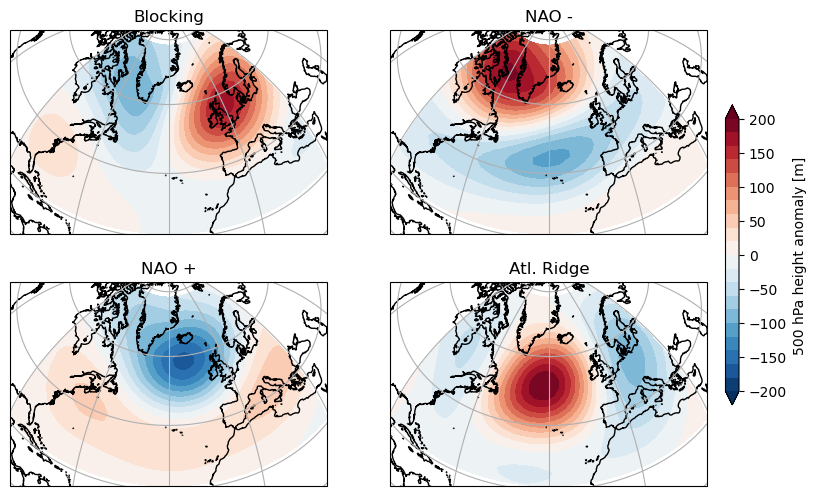

In [41]:
lons = recons_cluster_centers_unweighted.coords['lon'].values 
lats = recons_cluster_centers_unweighted.coords['lat'].values

plot_clusters(recons_cluster_centers_unweighted, lons, lats)

### 4. Iterate over all runs and assign to centroids

In [111]:
runstop = 170
for run in tqdm(range(10, runstop)): # full 10,170
    df_cluster_run = assign_to_cluster(run, recons_cluster_centers_unweighted)
    df_cluster_run.to_csv(f'{dir_Clusters}clusters_{run}.csv')

  0%|          | 0/160 [00:00<?, ?it/s]

### 5. Bayesian probabilistic assignment, and correction

In [20]:
runstop = 170

In [21]:
df_cluster_full = pd.concat([pd.read_csv(f'{dir_Clusters}clusters_{run}.csv', parse_dates=['time']) for run in range(10, runstop)])
df_cluster_full['all_errors'] = df_cluster_full['all_errors'].apply(lambda x: eval(x))

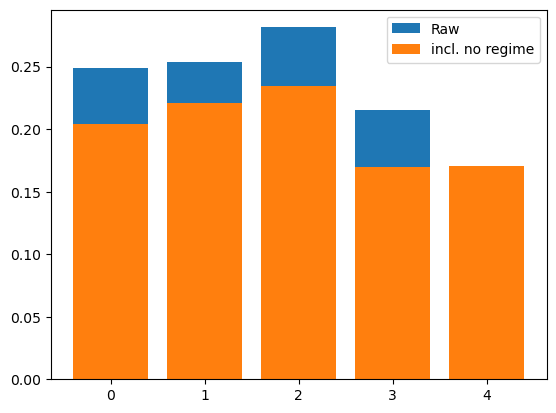

In [22]:
p_c, tau_matrix, dmean, dcov_inv, dcov_det = get_Bayes_parameters(df_cluster_full, N_CLUSTERS)
thres = 0.8 # If posterior probability of best-regime is below this threshold, assign to no regime
prior, likelihood, post, hard_assignment_raw, hard_assignment = bayes_posterior(df_cluster_full, p_c, tau_matrix, dmean, dcov_inv, dcov_det, thres, N_CLUSTERS)

# plot histogram of hard assignments
plt.hist(hard_assignment_raw, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], density=True, rwidth=0.8, label='Raw')
plt.hist(hard_assignment, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], density=True, rwidth=0.8, label='incl. no regime')
plt.legend()

(array([0.20407716, 0.22061302, 0.23463318, 0.17005535, 0.17062128]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

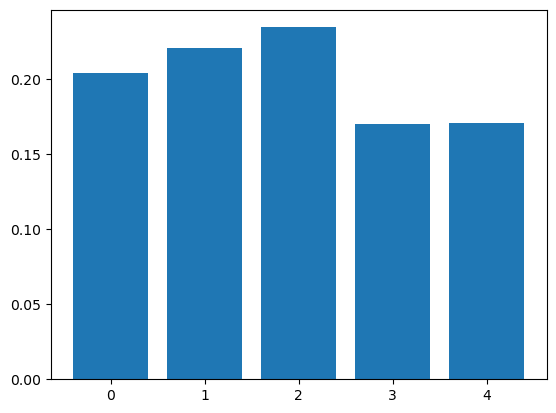

In [24]:
plt.hist(hard_assignment, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], density=True, rwidth=0.8, label='incl. no regime')


In [23]:
df_cluster_full['Bayes_cluster'] = hard_assignment
df_cluster_full['Bayes_cluster_raw'] = hard_assignment_raw

In [24]:
df_cluster_full.to_csv(f'{dir_Clusters}clusters_full.csv')

KeyError: 0

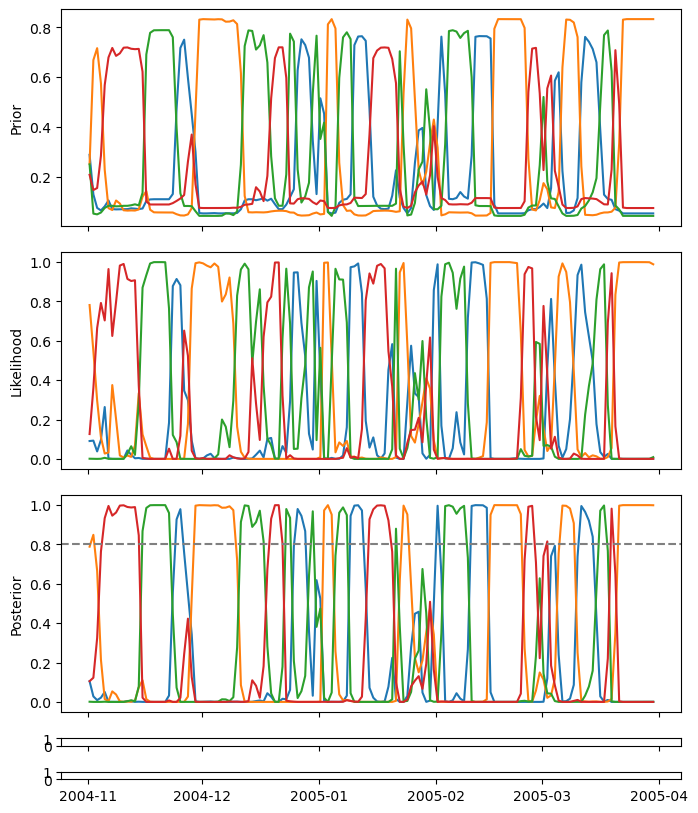

In [27]:
plot_bayes(df_cluster_full, prior, likelihood, post, hard_assignment, 2005, 12, 0.8)

In [ ]:
tau_matrix

array([[0.76482904, 0.05372746, 0.11060371, 0.07083979],
       [0.04485519, 0.83291816, 0.05770891, 0.06451774],
       [0.08338011, 0.04378427, 0.78857751, 0.0842581 ],
       [0.11524497, 0.07530721, 0.0895308 , 0.71991701]])